## set up

In [2]:
#set up
import torch, detectron2
from detectron2.utils.logger import setup_logger
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import ColorMode
import pandas as pd

%matplotlib inline

In [2]:
cfg = get_cfg()

#using mask-rcnn config, setting weight to model 0001399.pth
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

#maize setaria joint model
cfg.MODEL.WEIGHTS = "/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/training/output/model_final.pth"
#set confidence threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.82
predictor = DefaultPredictor(cfg)

## functions for running analysis

In [3]:
#functions for running analysis

#these parameters can be changed depending on exp
scan_x_dim=1008 #input scan dimensions
scan_y_dim=672
scan_overlap_length=266 #overlap amount between scans

def inferenceOnData(files,planting_date,genotype,treatment,savePath):
        def buildInferenceTable(image_id, outputs):
            #generate temp dataframe for individual image
            df = pd.DataFrame(columns=['image_id', 'planting_date', 'genotype', 'treatment', 'pistil_area', 'pistil_circularity', 'bbox', 'segm', 'confidence', 'center_x', 'center_y', 'perimeter_intersect', 'possible_overlap'])
            if len(outputs["instances"])==0:
                print("No detections for image")
                return df
            for i in range(0,len(outputs["instances"])):
                pred = outputs["instances"][i]
                pmask = pred.pred_masks.numpy().astype(int)[0]
                df.loc[len(df.index)] = [str(image_id),
                                         str(planting_date),
                                         str(genotype), 
                                         str(treatment),
                                         calcAreaOfBinaryMask(pmask),
                                         calcCircularity(pmask),
                                         pred.pred_boxes.tensor.numpy(),
                                         str(binaryMaskToRLE(pmask.astype(np.uint8))),
                                         pred.scores.numpy()[0],
                                         getDetectionCenter(pmask)[0],
                                         getDetectionCenter(pmask)[1],
                                         checkPerimeterIntersect(pmask),
                                         checkScanOverlap(pmask)]
            return df

        all_dfs = pd.DataFrame()
        for f in files:
            im = cv2.imread(f)
            #run inference
            outputs = predictor(im)
            #send output to analysis
            all_dfs = pd.concat([all_dfs, buildInferenceTable(f, outputs)])
            print("Progress:", files.index(f), "/", len(files), "Running inference on", f)
            #print(all_dfs) for debug
            
        #once all inference is done, extract plant_id, scan_position, and scan_angle from image name
        all_dfs["position_y"] = all_dfs['image_id'].str.find('~')
        all_dfs["scan_position"] = all_dfs.apply(lambda row: row['image_id'][row["position_y"] + 1 : row["position_y"] + 3], axis=1)
        all_dfs["scan_angle"] = all_dfs.apply(lambda row: row['image_id'][row["position_y"] + 9 : row["position_y"] + 11], axis=1)
        all_dfs["plant_id"] = all_dfs.apply(lambda row: row['image_id'][row["position_y"] - 6 : row["position_y"] ], axis=1)
        all_dfs = all_dfs.drop('position_y', axis=1)
        all_dfs["total_scans_for_sample"] = all_dfs.groupby("plant_id")["scan_position"].transform('max')
        all_dfs.loc[all_dfs["scan_position"] == "00", "possible_overlap"] = False #if the scan position is 0 (bottom), set bottom overlap to false. (The first scan cannot have overlap there)
        
        #correct y position for each detection to account for scan overlap
        all_dfs["center_y"] = scan_y_dim - all_dfs["center_y"] #flip the center_y values so it is going from bottom to top (px 0 is at bottom and 672 is at top of scan)
        all_dfs["y_pos_all_overlapped"] = ((all_dfs["scan_position"].astype(int)+1) * all_dfs["center_y"]) - scan_overlap_length #multiply scan y position by detection y position. Subtract overlap amount for correction.
        all_dfs.loc[all_dfs["scan_position"] == "00", "y_pos_all_overlapped"]  = all_dfs[all_dfs["scan_position"] == "00"]["y_pos_all_overlapped"] + scan_overlap_length
        all_dfs["y_pos_all_overlapped_len_standardized"] = all_dfs["y_pos_all_overlapped"].astype(int) / ((all_dfs["total_scans_for_sample"].astype(int)+1)*scan_y_dim) #divide the position by the sample length

        #save final unfiltered dataframe
        all_dfs.to_csv(savePath + ".csv")
        
        #filter and save filtered dataframe
        all_dfs=all_dfs[all_dfs.pistil_circularity<=1]
        all_dfs=all_dfs[all_dfs["possible_overlap"]==False]
        all_dfs.to_csv(savePath + "_filtered.csv")
        
        return all_dfs

In [4]:
from pycocotools import mask

#assuming mask is [0,1] format
def calcAreaOfBinaryMask(pmask):
    return np.sum(pmask)

def calcPerimeterofBinaryMask(pmask):
    contours, _ = cv2.findContours(pmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    perimeter = cv2.arcLength(contours[0], True)
    return perimeter
    
def calcCircularity(pmask):
    pmask = pmask.astype(np.uint8)
    perimeter = calcPerimeterofBinaryMask(pmask)
    area = calcAreaOfBinaryMask(pmask)
    circularity = ((4 * np.pi * area)) / (perimeter * perimeter)
    return circularity

def binaryMaskToRLE(pmask):
    return mask.encode(np.asfortranarray(pmask))

#does the pistil intersect with the perimeter of the image?
def checkPerimeterIntersect(pmask):
    pmask = pmask.astype(np.uint8)
    top_edge = np.any(pmask[0, :] > 0)
    bottom_edge = np.any(pmask[-1, :] > 0)
    left_edge = np.any(pmask[:, 0] > 0)
    right_edge = np.any(pmask[:, -1] > 0)
    intersects = top_edge or bottom_edge or left_edge or right_edge
    return intersects

#is the pistil in an overlapping part of the scan? Flag so it doesn't get counted twice.
#all images are 1008x672 resolution
def checkScanOverlap(pmask):
    y_dimension = scan_y_dim #change if using different dimension images
    bottom_overlap_region = scan_y_dim - scan_overlap_length #y coords flipped in this axis
    y_center = getDetectionCenter(pmask)[1]
    return y_center > bottom_overlap_region

def getDetectionCenter(pmask):
    pmask = pmask.astype(np.uint8)
    y1,y2,x1,x2 = get_bounding_box(pmask)
    y_center = (y1+y2)/2
    x_center = (x1+x2)/2
    return x_center, y_center


In [5]:
#decode RLE mask to binary mask, crop, display all masks
import ast
#mask.decode(ast.literal_eval(finalDf.segm[0]))

def get_bounding_box(pmask):
    # Get the rows and columns where the mask is non-zero
    rows = np.any(pmask, axis=1)
    cols = np.any(pmask, axis=0)
    # Get the bounding box
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

## run inference on individual datasets

In [31]:
#specify dataset (using 21UM data)

planting_date="late_planting" #early or late
genotype="gt1ra3tb1"#"tb1ra3""gt1-P_test"
treatment="no_treatment" #or defoliated
directory="/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/" + planting_date + "/" + genotype #+ "/"+ treatment
print(directory)
#print(planting_date, genotype, treatment)
all_items = os.listdir(directory)
print("Total images, all angles:", len(all_items))
#filter images for angle 08
files08 = [os.path.join(directory, item) for item in all_items if item.endswith('08.jpg') and os.path.isfile(os.path.join(directory, item))]
print("Images angle 08:", len(files08))

/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1
Total images, all angles: 742
Images angle 08: 53


In [32]:
finalDf = inferenceOnData(files08, planting_date, genotype, treatment, "results/21UM/late_tb1gt1ra3_no_treatment_jointModel")
finalDf

Progress: 0 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-5~0000000008.jpg
Progress: 1 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-5~0100000008.jpg
Progress: 2 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-5~0200000008.jpg
Progress: 3 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-5~0300000008.jpg
Progress: 4 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-5~0400000008.jpg
Progress: 5 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpe

/tmp/ipykernel_1571381/3155404443.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = ((4 * np.pi * area)) / (perimeter * perimeter)


Progress: 17 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-8~0100000008.jpg
Progress: 18 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-8~0200000008.jpg
Progress: 19 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-8~0300000008.jpg
Progress: 20 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-8~0400000008.jpg
Progress: 21 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3tb1/447-8~0500000008.jpg
Progress: 22 / 53 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass

,image_id,planting_date,genotype,treatment,pistil_area,pistil_circularity,bbox,segm,confidence,center_x,center_y,perimeter_intersect,possible_overlap,scan_position,scan_angle,plant_id,total_scans_for_sample,y_pos_all_overlapped,y_pos_all_overlapped_len_standardized
0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2775,0.871579,"[[504.00076, 243.26247, 566.3153, 305.3878]]","{'size': [672, 1008], 'counts': b'de[:a0Zd07K5...",0.996654,533.5,398.0,False,False,00,08,/447-5,07,398.0,0.074033
1,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,3113,0.896826,"[[270.27542, 75.479034, 325.11438, 148.49294]]","{'size': [672, 1008], 'counts': b'Wna5<2NRd0c0...",0.994615,297.5,560.0,False,False,00,08,/447-5,07,560.0,0.104167
2,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2637,0.825402,"[[419.01242, 97.72759, 468.31244, 169.9214]]","{'size': [672, 1008], 'counts': b'nRc8e0Xd05M1...",0.994087,443.0,537.0,False,False,00,08,/447-5,07,537.0,0.099888
3,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2182,0.867542,"[[478.66995, 233.07654, 526.7166, 297.29633]]","{'size': [672, 1008], 'counts': b'ccj91fd0>H6J...",0.993242,501.5,406.0,False,False,00,08,/447-5,07,406.0,0.075521
4,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2367,0.868584,"[[407.73077, 116.62435, 452.4945, 182.507]]","{'size': [672, 1008], 'counts': b'dl[8:]d0=F=G...",0.989324,429.5,522.5,False,False,00,08,/447-5,07,522.5,0.097098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,3417,0.863505,"[[460.3995, 344.79495, 521.6807, 423.50766]]","{'size': [672, 1008], 'counts': b'Tm^9l0Rd03M3...",0.975870,490.5,287.5,False,False,04,08,/448-8,06,1171.5,0.248937
10,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2952,0.877731,"[[448.1187, 200.6863, 503.55963, 275.25864]]","{'size': [672, 1008], 'counts': b'mWV97Yd0f0G5...",0.960431,474.5,433.0,False,False,04,08,/448-8,06,1899.0,0.403699
11,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2919,0.843707,"[[475.5109, 243.01654, 537.21826, 309.32855]]","{'size': [672, 1008], 'counts': b'edh9o0Pd01O1...",0.947374,505.5,396.0,False,False,04,08,/448-8,06,1714.0,0.364371
0,/work/pi_mbartlett_umass_edu/AmberDeNeve/grass...,late_planting,gt1ra3tb1,no_treatment,2545,0.867331,"[[444.92523, 213.2684, 497.1499, 280.79108]]","{'size': [672, 1008], 'counts': b'hXT9h0Qd09L3...",0.989938,470.0,424.5,False,False,05,08,/448-8,06,2281.0,0.484906


## run inference on all datasets (all groups)

In [19]:
planting_dates=["early_planting","late_planting"]
genotypes=["B73", "gt1B73", "ra3B73", "gt1ra3B73"]
treatments=["no_treatment","defoliated"]

for p in planting_dates:
    for g in genotypes:
        for t in treatments:
            print("Starting inference on new group:", p,g,t)
            directory="/work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/" + p + "/" + g + "/"+ t
            #print(directory)
            try:
                all_items = os.listdir(directory)
                #print("Total images, all angles:", len(all_items))
                #filter images for angle 08
                files08 = [os.path.join(directory, item) for item in all_items if item.endswith('08.jpg') and os.path.isfile(os.path.join(directory, item))]
                print("Images angle 08:", len(files08))
                prefix="results/" + p + "_" + g + "_" + t + "_jointModel"
                print("Save prefix:", prefix)
                inferenceOnData(files08, p, g, t, prefix)
                print("Finished group.")
            except Exception as e:
                print("~~ Not Found ~~")
                continue

Starting inference on new group: early_planting B73 no_treatment
Images angle 08: 37
Save prefix: early_planting_B73_no_treatment_jointModel
No detections for image
Progress: 0 / 37 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/B73/no_treatment/155-6~0000000008.jpg
No detections for image
Progress: 1 / 37 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/B73/no_treatment/155-6~0100000008.jpg
No detections for image
Progress: 2 / 37 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/B73/no_treatment/155-6~0200000008.jpg
No detections for image
Progress: 3 / 37 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/B73/no_treatment/155-6~0300000008.jpg
No 

Progress: 1 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/153-2~0100000008.jpg
No detections for image
Progress: 2 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/153-2~0200000008.jpg
No detections for image
Progress: 3 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/153-2~0300000008.jpg
No detections for image
Progress: 4 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/153-2~0400000008.jpg
Progress: 5 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B

No detections for image
Progress: 40 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/157-8~0400000008.jpg
No detections for image
Progress: 41 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/157-8~0500000008.jpg
No detections for image
Progress: 42 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/157-8~0600000008.jpg
No detections for image
Progress: 43 / 44 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1B73/no_treatment/157-8~0700000008.jpg
Finished group.
Starting inference on new group: early_planting gt1B73 defoliated
Images angle 08: 11
Save prefix: early_plantin

Progress: 10 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/154-2~0100000008.jpg
Progress: 11 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/154-2~0200000008.jpg
Progress: 12 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/154-2~0300000008.jpg
Progress: 13 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/154-2~0400000008.jpg
Progress: 14 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/154-2~0500000008.jpg
Progress: 15 / 

Progress: 52 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/158-2~0000000008.jpg
Progress: 53 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/158-2~0100000008.jpg
Progress: 54 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/158-2~0200000008.jpg
Progress: 55 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/158-2~0300000008.jpg
Progress: 56 / 80 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/no_treatment/158-2~0400000008.jpg
Progress: 57 / 

Progress: 13 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/154-3~0300000008.jpg
Progress: 14 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/154-3~0400000008.jpg
No detections for image
Progress: 15 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/154-3~0500000008.jpg
Progress: 16 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/154-5~0000000008.jpg
Progress: 17 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/154-5~0100000008.jpg
P

Progress: 55 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/158-7~0400000008.jpg
Progress: 56 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/158-7~0500000008.jpg
Progress: 57 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/158-7~0600000008.jpg
Progress: 58 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/158-9~0000000008.jpg
Progress: 59 / 63 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/early_planting/gt1ra3B73/defoliated/158-9~0100000008.jpg
Progress: 60 / 63 Running

No detections for image
Progress: 14 / 15 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1B73/defoliated/408-9~0800000008.jpg
Finished group.
Starting inference on new group: late_planting ra3B73 no_treatment
Images angle 08: 5
Save prefix: late_planting_ra3B73_no_treatment_jointModel
No detections for image
Progress: 0 / 5 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/ra3B73/no_treatment/403-2~0000000008.jpg
Progress: 1 / 5 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/ra3B73/no_treatment/403-2~0100000008.jpg
Progress: 2 / 5 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/ra3B73/no_treatment/403-2~0200000008.jpg
Progress: 3 / 5 Running infe

Progress: 34 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/405-8~0500000008.jpg
Progress: 35 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/405-8~0600000008.jpg
Progress: 36 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/405-8~0700000008.jpg
Progress: 37 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/405-8~0800000008.jpg
Progress: 38 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/405-8~0900000008.jpg
Progress: 39 / 88 Ru

Progress: 76 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/409-6~0800000008.jpg
Progress: 77 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/409-6~0900000008.jpg
Progress: 78 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/409-8~0000000008.jpg
Progress: 79 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/409-8~0100000008.jpg
Progress: 80 / 88 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/no_treatment/409-8~0200000008.jpg
Progress: 81 / 88 Ru

Progress: 30 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/405-7~0700000008.jpg
Progress: 31 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/405-9~0000000008.jpg
Progress: 32 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/405-9~0100000008.jpg
Progress: 33 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/405-9~0200000008.jpg
Progress: 34 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/405-9~0300000008.jpg
Progress: 35 / 85 Running infe

/tmp/ipykernel_1571381/3155404443.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = ((4 * np.pi * area)) / (perimeter * perimeter)


Progress: 68 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/409-7~0000000008.jpg
Progress: 69 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/409-7~0100000008.jpg
Progress: 70 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/409-7~0200000008.jpg
Progress: 71 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/409-7~0300000008.jpg
Progress: 72 / 85 Running inference on /work/pi_mbartlett_umass_edu/AmberDeNeve/grass_carpel_ml_quantification_final/data/maize_21UM_data/late_planting/gt1ra3B73/defoliated/409-7~0400000008.jpg
Progress: 73 / 85 Running infe

In [3]:
#combine all dataframes
import glob
# Step 1: Get a list of all CSV files
csv_files = glob.glob('results/*filtered.csv')
# Step 2: Loop through the files and read each one into a DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
# Step 3: Concatenate all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv("results/all_filtered_combined.csv")

## view prediction masks, grid

In [86]:
def display_masks_grid(masks, rows=9, cols=10):
    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    # Flatten axes for easy iteration
    axes_flat = axes.ravel()
    # Turn off axes for any unused subplots
    for ax in axes_flat[len(masks):]:
        ax.axis('off')
    # Display each mask
    for ax, mask in zip(axes_flat, masks):
        ax.imshow(1 - mask, cmap='gray')  # Invert the color
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [87]:
maskList=[]
finalDf = finalDf.sort_values("pistil_circularity")
finalDf = finalDf.reset_index(drop="True")
for row in finalDf.segm:
    pmask=mask.decode(ast.literal_eval(row))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    #crop mask using bounding box
    pmask=pmask[rmin:(rmax+1),cmin:(cmax+1)]
    maskList.append(pmask)

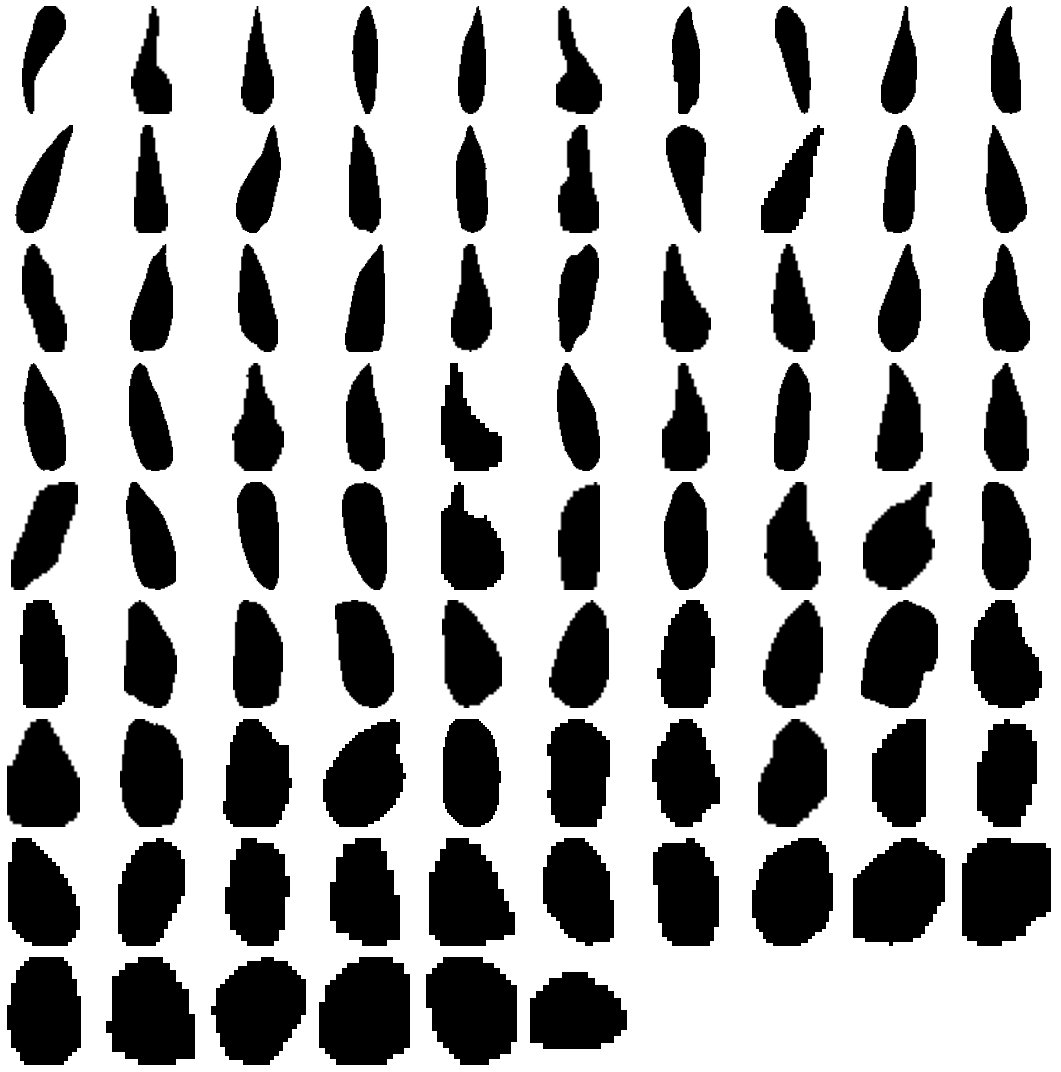

In [71]:
display_masks_grid(maskList) #gt1-P test

<AxesSubplot:xlabel='pistil_area', ylabel='pistil_circularity'>

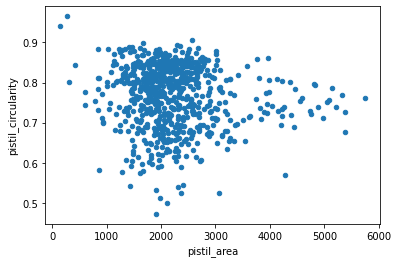

In [97]:
#circularity vs. area for gt1P
finalDf.plot("pistil_area","pistil_circularity",kind="scatter")

In [101]:
finalDf.segm[0]

"{'size': [672, 1008], 'counts': b'Ucd7o0nc0:F9H5K6J5L2L5L3M3M3M2O1M3M3N2N2O10O2O002L7J4M>B1OO1C=1O3dM`]OQ2jb0WO`]OjNcb0S1S1ZOUX[<'}"

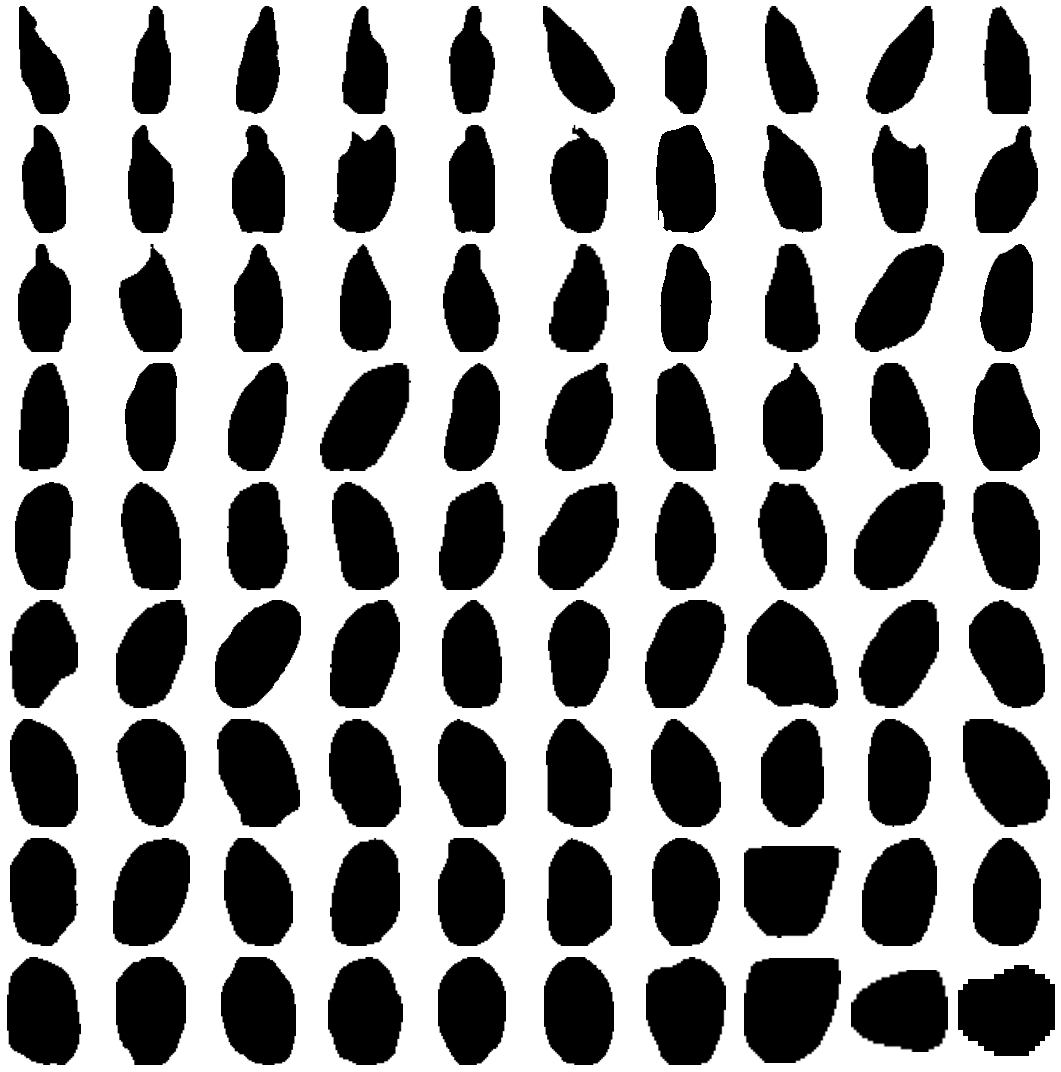

In [89]:
maskList=[]
finalDfSample = finalDf.sample(90)
finalDfSample = finalDfSample.sort_values("pistil_circularity")
finalDfSample = finalDfSample.reset_index(drop="True")
for row in finalDfSample.segm:
    pmask=mask.decode(ast.literal_eval(row))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    #crop mask using bounding box
    pmask=pmask[rmin:(rmax+1),cmin:(cmax+1)]
    maskList.append(pmask)
display_masks_grid(maskList) #gt1ra3(early)

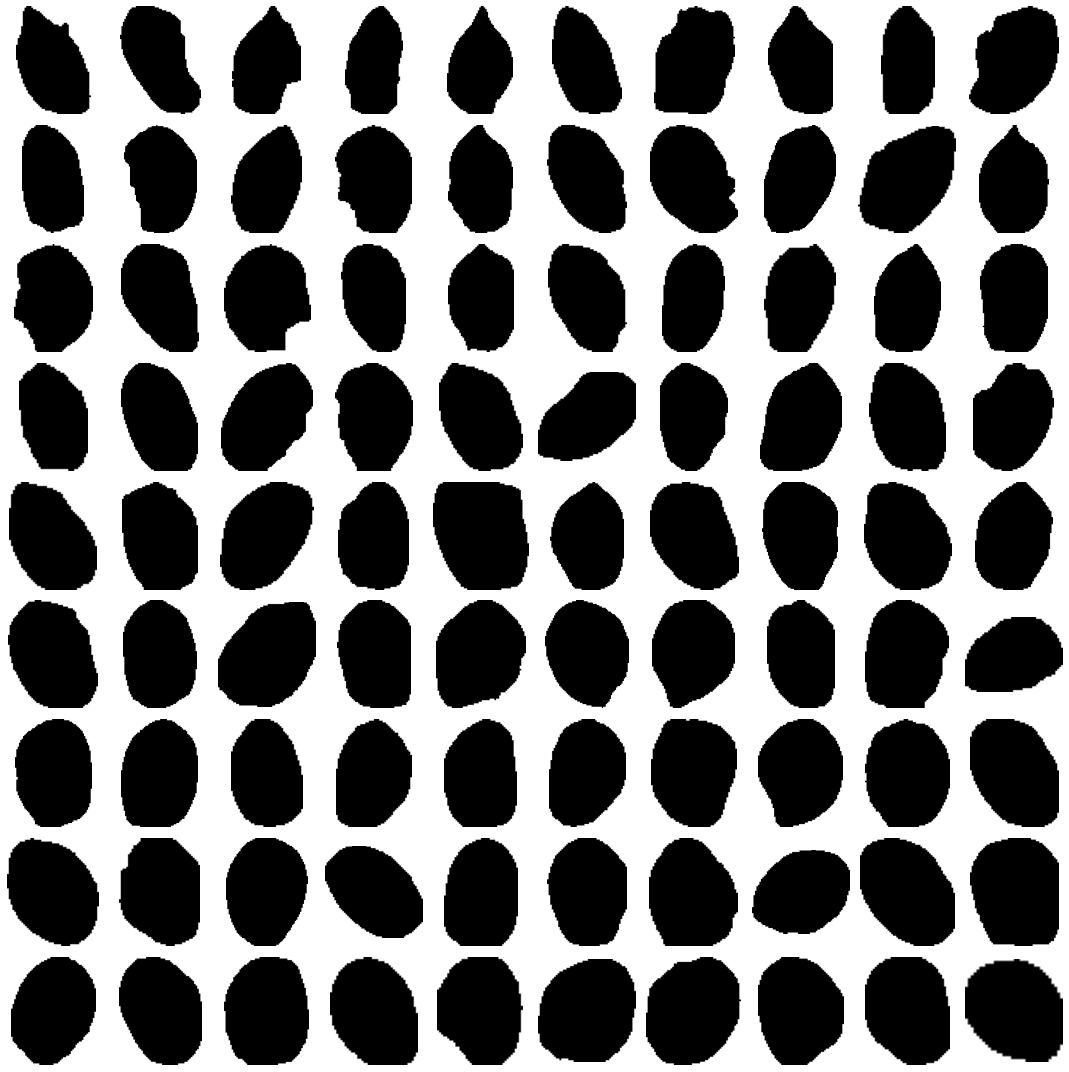

In [118]:
maskList=[]
finalDfSample = finalDf.sample(90)
finalDfSample = finalDfSample.sort_values("pistil_circularity")
finalDfSample = finalDfSample.reset_index(drop="True")
for row in finalDfSample.segm:
    pmask=mask.decode(ast.literal_eval(row))
    rmin, rmax, cmin, cmax = get_bounding_box(pmask)
    #crop mask using bounding box
    pmask=pmask[rmin:(rmax+1),cmin:(cmax+1)]
    maskList.append(pmask)
display_masks_grid(maskList) #tb1gt1ra3(late)